## 1. Problem Description and Related Work <a id="1"></a>

Business cycle describes the rise and fall in the growth of the economy that occurs over time. Each business cyle has two turning points trough (or bottom) and peak. Expansion is measured from the trough of the previous business cycle to the peak of the current cycle, while recession is measured from the peak to the trough. In the United States (US), the Business Cycle Dating Committee of the National Bureau of Economic Research (NBER) determines the dates for business cycles. The turning points are determined by considering monthly growth indicators of the economy such as industrial production, employment, real income. The main focus of business cycle analysis is to analyze why economy goes through contraction and expansion periods. It is a well-studied topic in the literature and still an active reserach area. In our work, we are going to predict recessions in US economy with leading macroeconomic indicators using machine learning algorithms.

## 2. Understand Data <a id="2"></a>

### 2.0 Set Up Environment <a id="2.0"></a>

In [34]:
# load libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #for correlation heatmap
import warnings
warnings.filterwarnings('ignore')
import os

from statsmodels.tsa.stattools import adfuller #to check unit root in time series 
from statsmodels.tsa.stattools import acf, pacf #to check autocorrelation and partial autocorrelation

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

### 2.1 Read Data and Description of the Variables <a id="2.1"></a>

For our analysis we will use a large macroeconomic database from FRED St. Louis designed by [McCracken and Ng (2015)](#i). It involves 129 macroeconomic monthly time series over the period 1959-2018. The data is organized into 8 categories (1)output and income, (2)labor market, (3)housing, (4)consumption, orders and inventories, (5)money and credit, (6)interest and exchange rates, (7)prices and (8)stock market. Detail description of the variables under each category can be found in __[appendix]( https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/Appendix_Tables_Update.pdf)__.

In [3]:
# Load US recession indicator and process it
usrec = pd.read_csv("data/USREC.csv", parse_dates=["observation_date"])
usrec = usrec[usrec["observation_date"] >= "1959-01-01"].copy()
usrec["Regime"] = usrec["USREC"].map({1: "Recession", 0: "Normal"})
usrec = usrec.rename(columns={"observation_date": "Date"})

# Load the data again, treating row 1 as data and row 0 as header
fred_md = pd.read_csv("data/fred-md-current.csv", skiprows=[1])

# Confirm correct column name for the date column
fred_md = fred_md.rename(columns={"sasdate": "Date"})

# Convert both to datetime
fred_md["Date"] = pd.to_datetime(fred_md["Date"])
usrec["Date"] = pd.to_datetime(usrec["Date"])

# Merge on Date
merged = fred_md.merge(usrec[["Date", "Regime"]], on="Date", how="left")

# Move Regime to second column
cols = merged.columns.tolist()
if "Regime" in cols:
    cols.insert(1, cols.pop(cols.index("Regime")))
    merged = merged[cols]

# Preview
merged.head()

,Date,Regime,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,1959-01-01,Normal,2583.560,2426.0,15.188,276676.8154,18235.77392,21.9616,23.3868,22.2620,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
1,1959-02-01,Normal,2593.596,2434.8,15.346,278713.9773,18369.56308,22.3917,23.7024,22.4549,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
2,1959-03-01,Normal,2610.396,2452.7,15.491,277775.2539,18523.05762,22.7142,23.8459,22.5651,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
3,1959-04-01,Normal,2627.446,2470.0,15.435,283362.7075,18534.46600,23.1981,24.1903,22.8957,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
4,1959-05-01,Normal,2642.720,2486.4,15.622,285307.2201,18679.66354,23.5476,24.3911,23.1161,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN


Consistent with the previous works in the literature, we use __[business cycle dating chronology provided by NBER](http://www.nber.org/cycles.html)__  which involves dates when recession began and ended in US economy. According to NBER's statistics we have 8 recession periods in our dataset where duration is changing from 6 to 18 months. We represent regimes as "Normal" and "Recession" in our dataset. 

In [5]:
merged[["Date","Regime"]].groupby("Regime").count()

,Date
Regime,
Normal,699
Recession,95


Preparation of the dataset for recession forecasting. Cleaning of the data and feature selection to reduce the number of variables in the data.

## 2. Data Cleaning <a id="2"></a>

We will follow the steps below to clean data and make it ready for feature selection process.

1. Remove the variables with missing observations
2. Add lags of the variables as additional features
3. Test stationarity of time series
4. Standardize the dataset

In [6]:
#remove columns with missing observations
missing_colnames=[]
for i in merged.drop(['Date','Regime'],axis=1):
    observations=len(merged)-merged[i].count()
    if (observations>10):
        print(i+':'+str(observations))
        missing_colnames.append(i)
 
merged = merged.drop(labels=missing_colnames, axis=1)

#rows with missing values
merged=merged.dropna(axis=0)

merged.shape

PERMIT:12
PERMITNE:12
PERMITMW:12
PERMITS:12
PERMITW:12
ACOGNO:398
ANDENOx:109
TWEXAFEGSMTHx:168
UMCSENTx:154
VIXCLSx:42


(791, 118)

In [7]:
# Add lags
for col in merged.drop(['Date', 'Regime'], axis=1):
    for n in [3,6,9,12,18]:
        merged['{} {}M lag'.format(col, n)] = merged[col].shift(n).ffill().values

# 1 month ahead prediction
merged["Regime"] = merged["Regime"].shift(-1)

merged = merged.dropna(axis=0)

In [8]:
merged.shape

(772, 698)

Augmented Dickey-Fuller Test can be used to test for stationarity in macroeconomic time series variables. We will use `adfuller` function from `statsmodels` module in Python. More information about the function can be found __[here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)__.

In [ ]:
# check stationarity
threshold = 0.01 #significance level
for column in merged.drop(['Date','Regime'], axis=1):
    result = adfuller(merged[column])
    if result[1] > threshold:
        merged[column] = merged[column].diff()
merged = merged.dropna(axis=0)

In [11]:
threshold = 0.01 #significance level
for column in merged.drop(['Date','Regime'], axis=1):
    result = adfuller(merged[column])
    if result[1] > threshold:
        merged[column] = merged[column].diff()
merged=merged.dropna(axis=0)

In [12]:
threshold = 0.01 #significance level
for column in merged.drop(['Date','Regime'], axis=1):
    result = adfuller(merged[column])
    if result[1] > threshold:
        print(column)
merged=merged.dropna(axis=0)

AWHMAN 6M lag


In [13]:
# Standardize
features=merged.drop(['Date','Regime'],axis=1)
col_names=features.columns

scaler=StandardScaler()
scaler.fit(features)
standardized_features=scaler.transform(features)
standardized_features.shape
df=pd.DataFrame(data=standardized_features,columns=col_names)
df.insert(loc=0,column="Date", value=merged['Date'].values)
df.insert(loc=1,column='Regime', value=merged['Regime'].values)
df.head()
df.shape

(770, 698)

In [14]:
df.to_csv("data/dataset_cleaned.csv", index=False)

In [16]:
df = pd.read_csv('data/dataset_cleaned.csv')

Label = df["Regime"].apply(lambda regime: 1. if regime == 'Normal' else 0.)
df.insert(loc=2, column="Label", value=Label.values)

df.head()

,Date,Regime,Label,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,...,DTCTHFNM 3M lag,DTCTHFNM 6M lag,DTCTHFNM 9M lag,DTCTHFNM 12M lag,DTCTHFNM 18M lag,INVEST 3M lag,INVEST 6M lag,INVEST 9M lag,INVEST 12M lag,INVEST 18M lag
0,1960-09-01,Recession,0.0,-0.088921,-0.281157,-0.132289,0.310600,-0.215082,-0.484379,-0.432151,...,-0.078571,-0.091591,-0.084825,-0.083113,-0.091394,-0.337219,-0.391339,-0.294510,-0.324057,-0.410591
1,1960-10-01,Recession,0.0,-0.067853,-0.162174,-0.128032,-0.758597,-0.172845,-0.181778,0.067616,...,-0.082348,-0.084958,-0.098594,-0.086387,-0.084336,-0.230676,-0.310169,-0.342167,-0.336245,-0.311800
2,1960-11-01,Recession,0.0,-0.160451,-0.532163,-0.413230,-0.474120,-0.273545,-0.597713,-0.515446,...,-0.085035,-0.087309,-0.092213,-0.091592,-0.082068,-0.310632,-0.297555,-0.407927,-0.320849,-0.371731
3,1960-12-01,Recession,0.0,-0.163711,-0.535423,-0.715454,0.054738,-0.242524,-0.748873,-0.640243,...,-0.093934,-0.077990,-0.091038,-0.084540,-0.072153,-0.271623,-0.330665,-0.393390,-0.290710,-0.417642
4,1961-01-01,Recession,0.0,0.007948,0.067643,-0.208909,-1.247846,-0.207684,-0.106269,-0.182268,...,-0.100651,-0.081768,-0.084405,-0.098309,-0.072741,-0.228112,-0.223222,-0.310983,-0.338638,-0.305470


In [17]:
df.tail()

,Date,Regime,Label,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,...,DTCTHFNM 3M lag,DTCTHFNM 6M lag,DTCTHFNM 9M lag,DTCTHFNM 12M lag,DTCTHFNM 18M lag,INVEST 3M lag,INVEST 6M lag,INVEST 9M lag,INVEST 12M lag,INVEST 18M lag
765,2024-07-01,Normal,1.0,-0.100063,-0.471856,0.819080,1.011207,1.744928,-1.176479,-1.233317,...,0.059221,-0.028558,0.107767,0.218654,-0.214860,-2.524452,0.683326,-2.590213,-1.389134,-1.048213
766,2024-08-01,Normal,1.0,-0.099338,-0.323535,-0.111005,-0.117105,-0.398084,0.559537,0.519496,...,0.109594,-0.168372,0.113650,0.274688,-0.267734,0.362414,-0.385644,-0.998861,-2.535579,-1.167176
767,2024-09-01,Normal,1.0,0.030784,-0.229000,1.063839,1.018842,1.250015,-0.740577,-0.965149,...,-0.127221,-0.022238,0.154906,0.150803,0.067305,2.572705,4.092015,2.886912,-1.561025,-6.637232
768,2024-10-01,Normal,1.0,0.182671,0.566395,0.048620,-0.490228,0.710466,-0.606010,-1.204005,...,0.184821,0.059806,-0.028006,0.108056,0.026385,1.607247,-2.536361,0.697666,-2.599442,-5.745167
769,2024-11-01,Normal,1.0,0.063331,0.375696,0.865903,0.538396,0.867153,-0.486910,-0.545629,...,0.125854,0.110180,-0.167819,0.113939,0.225746,1.979573,0.374875,-0.387609,-0.999059,-2.012307


Our exercise will be based on classification problem. We have two binary outcomes that we want to predict with certain variables. Here we will summarize our approach to predict recessions with machine learning algorithms.

1. We will perform feature selection before making our forecasts. We will use $L_1$ regularized logistic regression for that purpose.

2. Separate dataset into training and validation datasets. Split based dataset based on time: the period over 1960-1996 is selected for training and the period over 1996-2018 is kept for validation

3. Evaluate performances of the machine learning algorithms on training dataset with cross validation (CV). Since we have time series structure we will use a special type of CV function in Python,__[`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit)__. We will use Receiver operating characteristic (ROC) as scoring metric in our models. Related Python functions for this metric are __[`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)__  and  __[`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve)__.

4. Select the best performing models based on average accuracy and standard deviation of the CV results. We will take logistic regression as a benchmark model since this is the traditional method has been used to approach this problem.

5. Then we make predictions on the validation dataset with selected models. First, we use __[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)__ for selected model on training dataset to find best combination of parameters for the model. Then we evaluate the model on validation dataset and report accuracy metrics and feature importance results.

## 3. Feature Selection with $L_1$ Penalty <a id="3"></a>

In [18]:
# Time Series Split
df_idx = df[df.Date == '12/1/96'].index[0]

df_targets=df['Label'].values
df_features=df.drop(['Regime','Date','Label'], axis=1)

df_training_features = df.iloc[:df_idx,:].drop(['Regime','Date','Label'], axis=1)
df_validation_features = df.iloc[df_idx:, :].drop(['Regime','Date','Label'], axis=1)

df_training_targets = df['Label'].values
df_training_targets=df_training_targets[:df_idx]

df_validation_targets = df['Label'].values
df_validation_targets=df_validation_targets[df_idx:]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [21]:
import pandas as pd

# Make sure Date is in datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Define the correct split date (ensure format matches)
split_date = pd.Timestamp("1996-12-01")

# Get the index of the split date
split_idx = df.index[df["Date"] == split_date]

# Check that the date exists
if split_idx.empty:
    raise ValueError("The split date 1996-12-01 is not present in the 'Date' column.")

df_idx = split_idx[0]

# Proceed as originally planned
df_targets = df['Label'].values
df_features = df.drop(['Regime', 'Date', 'Label'], axis=1)

df_training_features = df.iloc[:df_idx, :].drop(['Regime', 'Date', 'Label'], axis=1)
df_validation_features = df.iloc[df_idx:, :].drop(['Regime', 'Date', 'Label'], axis=1)

df_training_targets = df['Label'].values[:df_idx]
df_validation_targets = df['Label'].values[df_idx:]

In [22]:
print(len(df_training_features),len(df_training_targets),len(df_targets))
print(len(df_validation_features),len(df_validation_targets),len(df_features))

435 435 770
335 335 770


In [24]:
scoring="roc_auc"
kfold= model_selection.TimeSeriesSplit(n_splits=3)
seed=8

# Create regularization hyperparameter space
C = np.reciprocal([0.00000001, 0.00000005, 0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 
                         0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000])

# Create hyperparameter options
hyperparameters = dict(C=C)

model = LogisticRegression(max_iter=10000,penalty='l1', solver='liblinear')
LR_penalty = model_selection.GridSearchCV(estimator = model, 
                                          param_grid = hyperparameters,
                                          cv = kfold, 
                                          scoring=scoring
                                        ).fit(X=df_features,y=df_targets).best_estimator_

LR_penalty

LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear')

In [26]:
X=df_features
y=df_targets
lr_l1 = LogisticRegression(C=0.1, max_iter=10000,penalty="l1", solver='liblinear').fit(X,y)
model = SelectFromModel(lr_l1,prefit=True)
feature_idx = model.get_support()
feature_name = X.columns[feature_idx]
X_new = model.transform(X)
X_new.shape

(770, 33)

In [27]:
feature_name

Index(['IPMANSICS', 'HWI', 'HWIURATIO', 'USGOOD', 'MANEMP', 'NDMANEMP',
       'HOUST', 'HOUSTW', 'M1SL', 'BUSLOANS', 'S&P div yield', 'FEDFUNDS',
       'TB6MS', 'COMPAPFFx', 'TB3SMFFM', 'USCONS 3M lag', 'USFIRE 3M lag',
       'USFIRE 18M lag', 'AMDMUOx 9M lag', 'S&P 500 6M lag',
       'S&P div yield 3M lag', 'S&P div yield 6M lag', 'FEDFUNDS 6M lag',
       'AAA 3M lag', 'TB3SMFFM 3M lag', 'TB3SMFFM 6M lag', 'T1YFFM 6M lag',
       'T5YFFM 6M lag', 'T10YFFM 9M lag', 'BAAFFM 12M lag', 'EXSZUSx 9M lag',
       'PPICMM 18M lag', 'CUSR0000SAD 6M lag'],
      dtype='object')

In [28]:
df_2=df[feature_name]
df_2.insert(loc=0, column="Date", value=df['Date'].values)
df_2.insert(loc=1, column="Regime", value=df['Regime'].values)
df_2.insert(loc=2, column="Label", value=df['Label'].values)

df_2.head()
df_2.shape

(770, 36)

<Axes: >

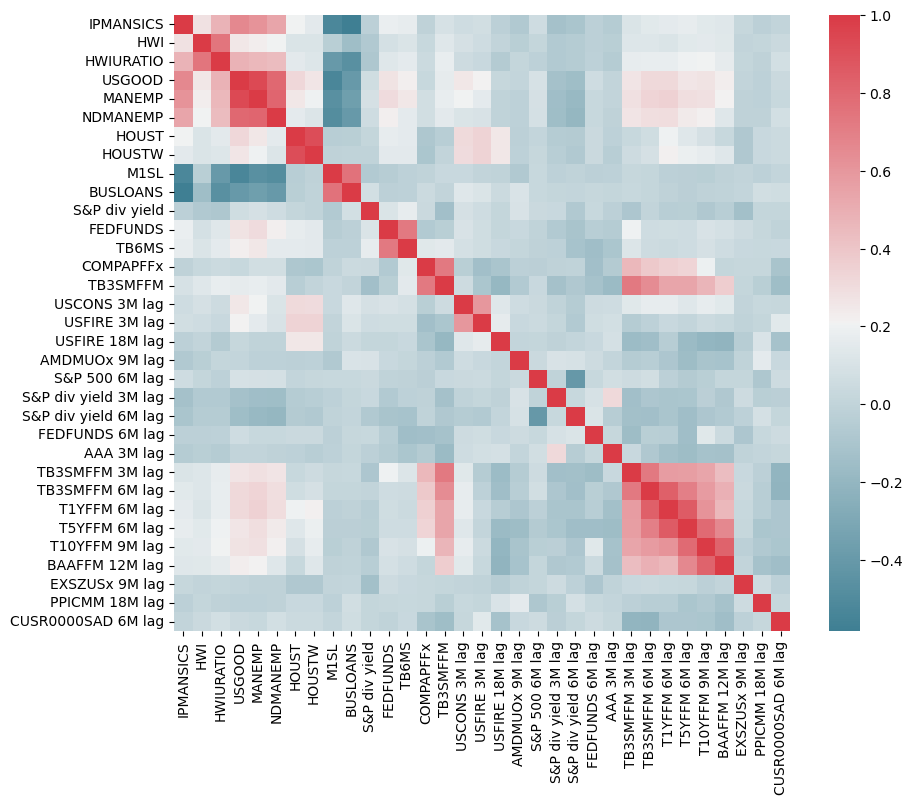

In [30]:
corr = df_2.drop(['Date','Regime','Label'],axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype = bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

## 4. Training Algorithms on Training Dataset <a id="3"></a>

In [31]:
df=df_2
df.shape

(770, 36)

In [32]:
# Time Series Split
df_idx = df[df.Date == '12/1/96'].index[0]

df_targets=df['Label'].values
df_features=df.drop(['Regime','Date','Label'], axis=1)

df_training_features = df.iloc[:df_idx,:].drop(['Regime','Date','Label'], axis=1)
df_validation_features = df.iloc[df_idx:, :].drop(['Regime','Date','Label'], axis=1)

df_training_targets = df['Label'].values
df_training_targets=df_training_targets[:df_idx]

df_validation_targets = df['Label'].values
df_validation_targets=df_validation_targets[df_idx:]

LR: 0.820191 (0.067608)
LR_L1: 0.944155 (0.020523)
LR_L2: 0.951346 (0.012388)
LDA: 0.877032 (0.026105)
KNN: 0.864501 (0.098868)
GB: 0.765406 (0.213741)
ABC: 0.911814 (0.022970)
RF: 0.889330 (0.094995)
XGB: 0.907378 (0.095275)


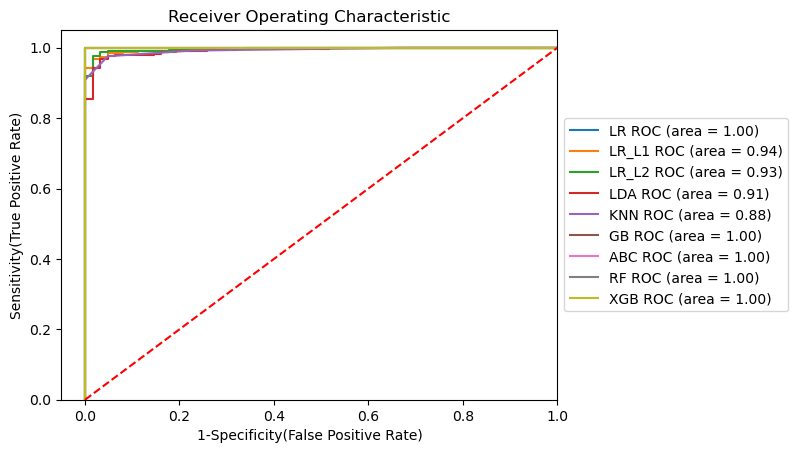

In [38]:
seed=8
scoring='roc_auc' 
kfold = model_selection.TimeSeriesSplit(n_splits=3) 
models = []

models.append(('LR', LogisticRegression(C=1e09)))
models.append(('LR_L1', LogisticRegression(penalty = 'l1', solver='liblinear')))
models.append(('LR_L2', LogisticRegression(penalty = 'l2')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', xgb.XGBClassifier()))

results = []
names = []
lb = preprocessing.LabelBinarizer()

for name, model in models:
    cv_results = model_selection.cross_val_score(estimator = model, X = df_training_features, 
                                                 y = lb.fit_transform(df_training_targets), cv=kfold, scoring = scoring)
    
    model.fit(df_training_features, df_training_targets) # train the model
    fpr, tpr, thresholds = metrics.roc_curve(df_training_targets, model.predict_proba(df_training_features)[:,1])
    auc = metrics.roc_auc_score(df_training_targets,model.predict(df_training_features))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 
warnings.filterwarnings('ignore')

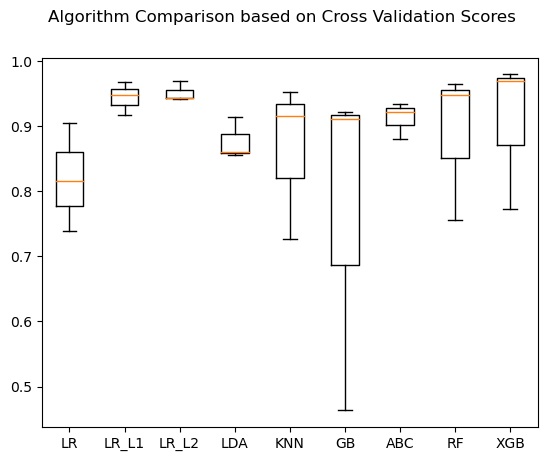

In [39]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison based on Cross Validation Scores')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## 4. Evaluate Performances of the Algorithms on Validation Dataset <a id="4"></a>

### Logistic Regression

In [40]:
model=LogisticRegression(C=1e09) # high penalty 
LR=model.fit(df_training_features,df_training_targets)
training_predictions=LR.predict(df_training_features)
prob_predictions = LR.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, LR.predict_proba(df_validation_features), axis=0)

In [41]:
import datetime
# define periods of recession
rec_spans = []
#rec_spans.append([datetime.datetime(1957,8,1), datetime.datetime(1958,4,1)])
rec_spans.append([datetime.datetime(1960,4,1), datetime.datetime(1961,2,1)])
rec_spans.append([datetime.datetime(1969,12,1), datetime.datetime(1970,11,1)])
rec_spans.append([datetime.datetime(1973,11,1), datetime.datetime(1975,3,1)])
rec_spans.append([datetime.datetime(1980,1,1), datetime.datetime(1980,6,1)])
rec_spans.append([datetime.datetime(1981,7,1), datetime.datetime(1982,10,1)])
rec_spans.append([datetime.datetime(1990,7,1), datetime.datetime(1991,2,1)])
rec_spans.append([datetime.datetime(2001,3,1), datetime.datetime(2001,10,1)])
rec_spans.append([datetime.datetime(2007,12,1), datetime.datetime(2009,5,1)])

ValueError: x and y must have same first dimension, but have shapes (697,) and (770,)

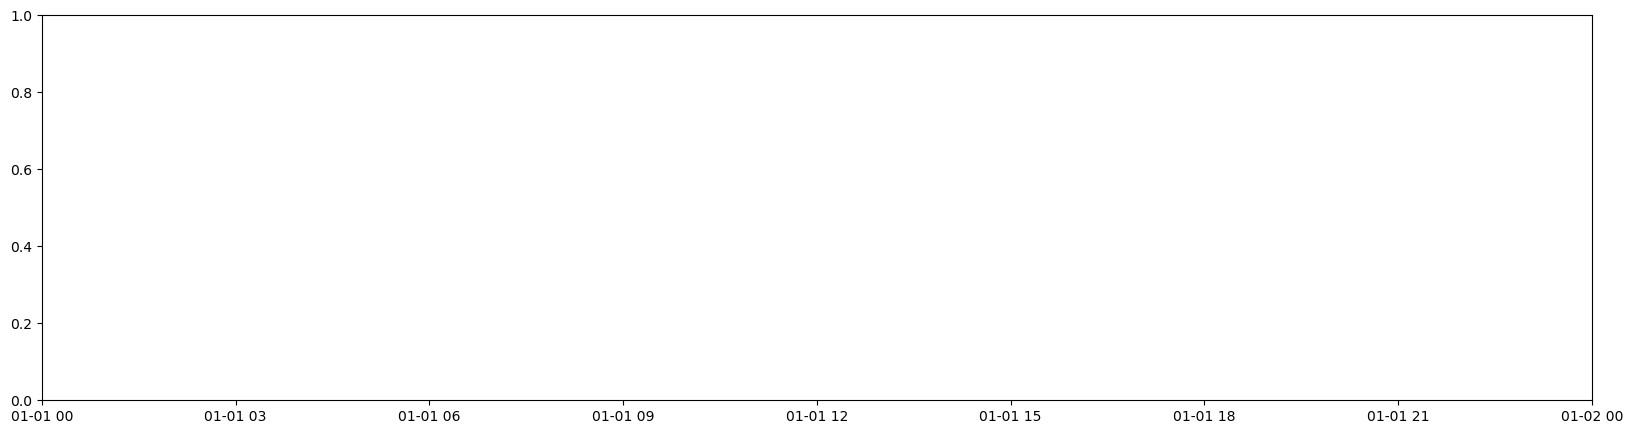

In [42]:
sample_range = pd.date_range(start='9/1/1960', end='9/1/2018', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with Logistic Regression')
plt.savefig('plot1.png',  bbox_inches='tight')
plt.show()

### Logistic Regression with Regularization

In [43]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.reciprocal([0.00000001, 0.00000005, 0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 
                         0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000])

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)


model=LogisticRegression(max_iter=10000)
LR_penalty=model_selection.GridSearchCV(estimator=model, param_grid= hyperparameters,
                                        cv=kfold, scoring=scoring).fit(df_training_features,
                                                                       df_training_targets).best_estimator_
training_predictions=LR_penalty.predict(df_training_features)

In [44]:
prob_predictions = LR_penalty.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, LR_penalty.predict_proba(df_validation_features), axis=0)

ValueError: x and y must have same first dimension, but have shapes (697,) and (770,)

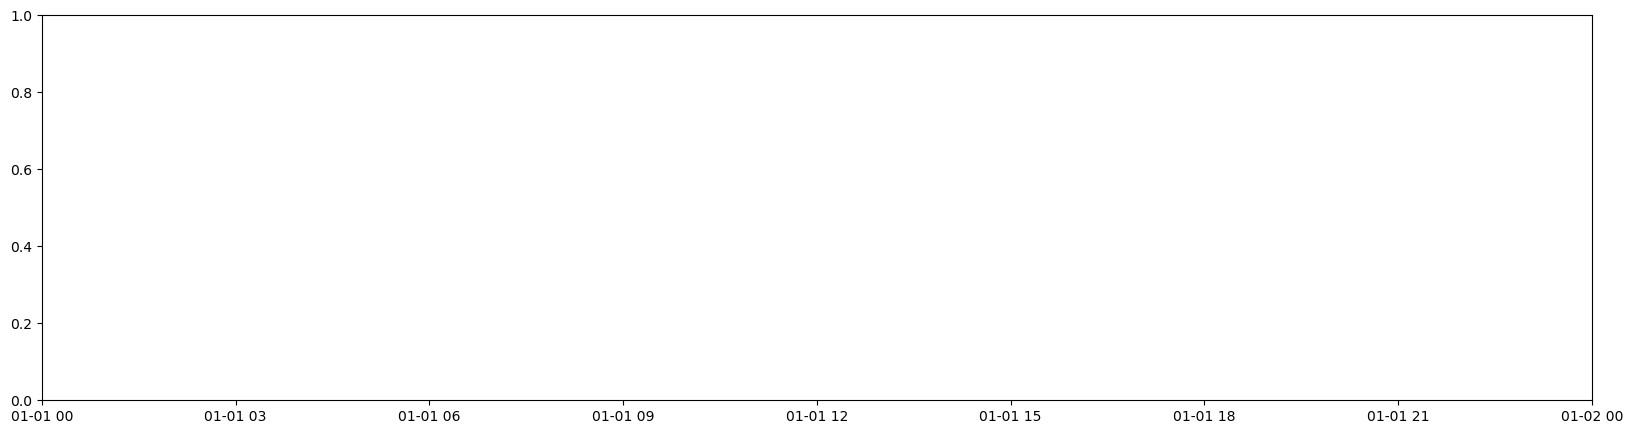

In [45]:
sample_range = pd.date_range(start='9/1/1960', end='9/1/2018', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with Regularized Logistic Regression')
mp.savefig('plot2.png',  bbox_inches='tight')
plt.show()

### XGBoosting

In [46]:
xgboost = model_selection.GridSearchCV(estimator=xgb.XGBClassifier(),
                                       param_grid={'booster': ['gbtree']},
                                       scoring=scoring, cv=kfold).fit(df_training_features, 
                                                                      lb.fit_transform(df_training_targets)).best_estimator_
xgboost.fit(df_training_features, df_training_targets)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [47]:
prob_predictions = xgboost.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, xgboost.predict_proba(df_validation_features), axis=0)

ValueError: x and y must have same first dimension, but have shapes (697,) and (770,)

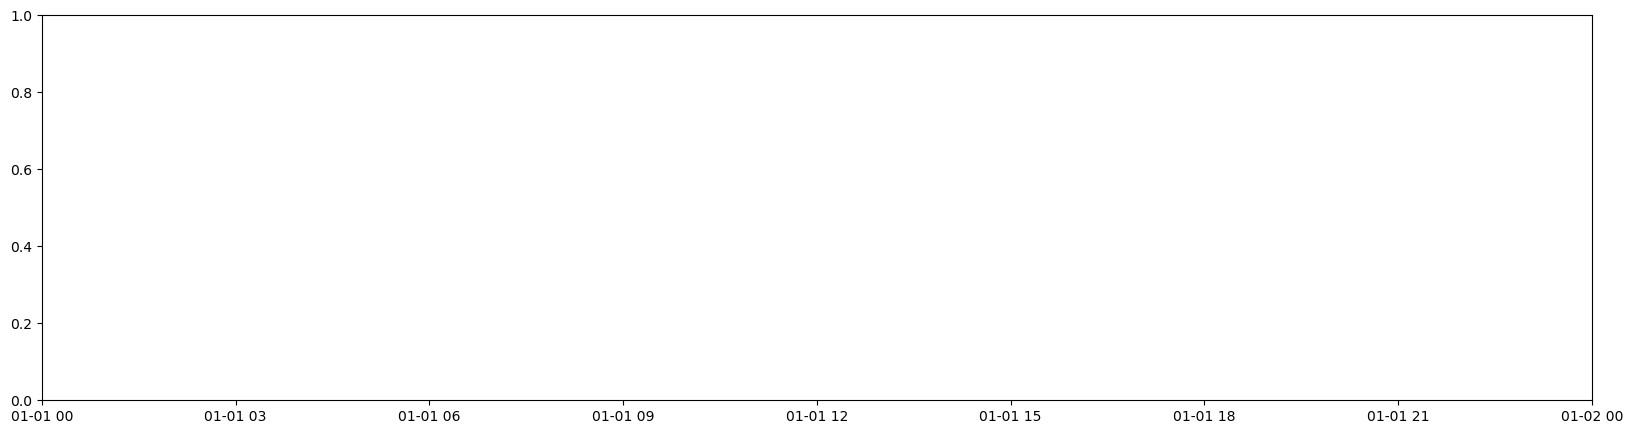

In [48]:
sample_range = pd.date_range(start='9/1/1960', end='9/1/2018', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with XGBoost')
mp.savefig('plot3.png',  bbox_inches='tight')
plt.show()

ValueError: rotation must be 'vertical', 'horizontal' or a number, not 90

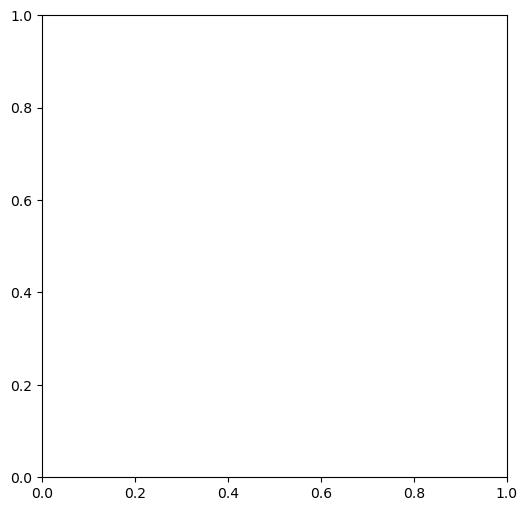

In [49]:
# find feature importances
headers = df.drop(['Regime','Label', 'Date'], axis=1).columns.values.tolist()
xgboost_importances = pd.DataFrame(xgboost.feature_importances_, index = headers, columns = ['Relative Importance'])
_ = xgboost_importances.sort_values(by = ['Relative Importance'], ascending = False, inplace=True)
xgboost_importances = xgboost_importances[xgboost_importances['Relative Importance']>0].iloc[:20]

# display importances in bar-chart and pie-chart
fig = plt.figure(figsize=(6,6))
plt.xticks(rotation='90')
plt.barh(y=np.arange(len(xgboost_importances)), width=xgboost_importances['Relative Importance'], align='center', tick_label=xgboost_importances.index)
plt.gca().invert_yaxis()
mp.savefig('feature_importance.png',  bbox_inches='tight')
plt.show()

NameError: name 'mp' is not defined

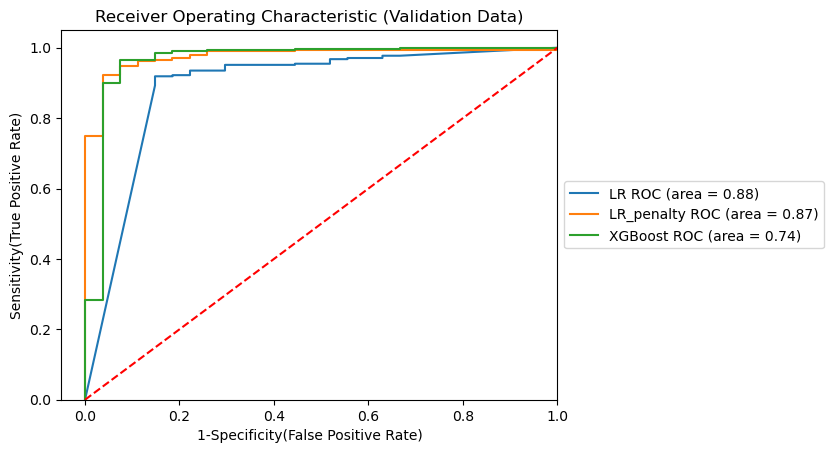

In [50]:
fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, LR.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets,LR.predict(df_validation_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR', auc))

fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, LR_penalty.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets,LR_penalty.predict(df_validation_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR_penalty', auc))

fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, xgboost.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets,xgboost.predict(df_validation_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('XGBoost', auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Validation Data)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mp.savefig('ROC1.png',  bbox_inches='tight')
plt.show() 

NameError: name 'mp' is not defined

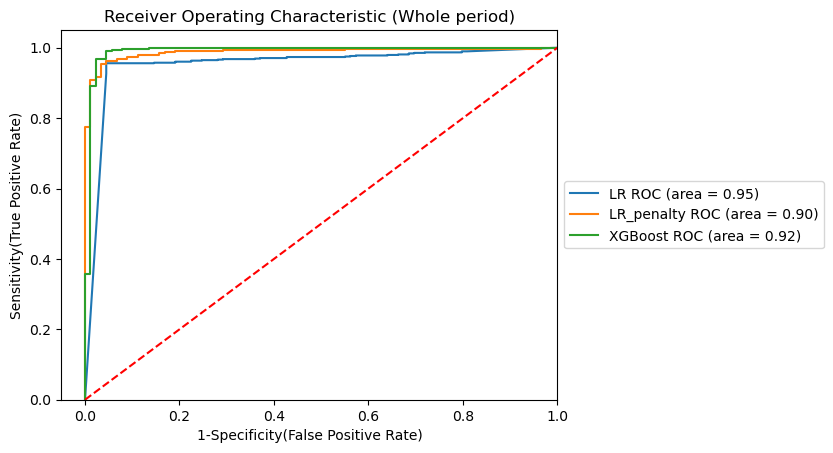

In [51]:
fpr, tpr, thresholds = metrics.roc_curve(df_targets, LR.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_targets,LR.predict(df_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR', auc))


fpr, tpr, thresholds = metrics.roc_curve(df_targets, LR_penalty.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_targets,LR_penalty.predict(df_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR_penalty', auc))

fpr, tpr, thresholds = metrics.roc_curve(df_targets, xgboost.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_targets,xgboost.predict(df_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('XGBoost', auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Whole period)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mp.savefig('ROC2.png',  bbox_inches='tight')
plt.show() 